## _ISS_ orbit determination from TLE


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import pandas as pd
import sys
from pandas import DataFrame, read_csv
from scipy.integrate import odeint
import io
import requests
from mpl_toolkits.basemap import Basemap


In [16]:
mu = 398600      #[m^3/s^2]
Re = 6378e3      #[m]
J2 = 1082e-6
#r = Re+500e3     #[m]
#we = 2*np.pi*(1 + 1/365.25)/(3600*24)

In [17]:
# Function to read the *.csv file
def read(loc):
    return pd.read_csv(loc, sep=";",header = None)

In [18]:
ISS_data  = read(r'./newISS.csv')

The next command will show the ISS Two Line Element set, what we have just read from the .csv file using Pandas.

In [19]:
ISS_data

,0,1,2,3,4,5,6,7,8
0,ISS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,25544U,98067A,16183.98843,0.000167,00000-0,10270-3,0.000000,9156.0
2,2,25544,51.6411,344.19360,1100.000000,11.0349,349.0828,15.548025,7286.0


In [20]:
ISS_array = ISS_data.values[2::3]
df_ISS = pd.DataFrame(ISS_array)

In [21]:
# slicing the array to get the items we need for our purposes.
df_ISS

,0,1,2,3,4,5,6,7,8
0,2,25544,51.6411,344.194,1100,11.0349,349.0828,15.548,7286


### Function to convert from TLE to COE (Classical Orbital Elements)



In [22]:
## Function to convert from TLE to COE (Classical Orbital Elements)

#    Input :
#    --------
#    TLE
    
#    Output:
#    --------
#    Inclination, RAAN, Eccentricity, argument of perigee, Mean Anomaly, Mean motion
    
#############################################################################

mu = 398600                             # Standard gravitational parameter for the earth
Re = 6371                               # Earth Radius [km]
def tle2coe(df):
    inc   = list(map(float,df[2]))      # Inclination [deg]
    RAAN  = list(map(float,df[3]))      # Right Ascension of the Ascending Node [deg]
    ecc   = list(map(float,df[4]))      # Eccentricity
    ecc[:] = [x / 1e7 for x in ecc]

    w     = list(map(float,df[5]))      # Argument of periapsis [deg]
    M     = list(map(float,df[6]))      # Mean anomaly [deg]
    n     = list(map(float,df[7]))      # Mean motion [Rev/ day]
    
    return np.array([inc,RAAN,ecc,w,M,n])

In [23]:
coe = tle2coe(df_ISS)

In [24]:
inc = np.deg2rad(coe[0])  # rad
RAAN = np.deg2rad(coe[1]) # rad
ecc = coe[2]
w = np.deg2rad(coe[3])    # rad
M = np.deg2rad(coe[4])    # rad
n = coe[5]

def Kepler(M,ecc):
    tol = 1e-8             
    En = M
    En1 = En - (En-ecc*np.sin(En)-M)/(1-ecc*np.cos(En)) 
    
    while ( abs(En1-En) > tol ):
        En = En1
        En1 = En - (En-ecc*np.sin(En)-M)/(1-ecc*np.cos(En))
    
    E = En1
    return E

In [25]:
# Orbital parametres
a = np.zeros_like(inc)
T = np.zeros_like(inc)
h_p = np.zeros_like(inc)
h_a = np.zeros_like(inc)
h  = np.zeros_like(inc)
E = np.zeros_like(inc)
theta = np.zeros_like(inc)
E0 = np.zeros_like(inc)
J_2 = 1.08263e-3

for i in range(len(coe[0])):
    a[i] = (mu/(n[i]*2*np.pi/(24*3600))**2)**(1/3)       # Semi-major axis [km]
    T[i] = 2*np.pi*np.sqrt((a[i]**3)/mu)                 # Period in [sec]
    h_p[i] = (1 - ecc[i])*a[i] - Re                      # Perigee Altitude [km]
    h_a[i] = (1 + ecc[i])*a[i] - Re                      # Apogee Altitude [km]
    h[i] = (mu*(h_p[i]+Re)*(1 + ecc[i]))**0.5            # Angular momentum
    E[i] = Kepler(M[i],ecc[i])
    theta[i] = np.arccos((np.cos(E[i])-ecc[i])/(1 - ecc[i]*np.cos(E[i])))    # [rad] True anomaly

### COE to RV

In [26]:
# COE to RV
def coe2rv(inc,ecc,RAAN,w,theta,h):
    
    rperi = ((h**2)/(mu*(1+ ecc *np.cos(theta))))*np.array([[np.cos(theta)], [np.sin(theta)], [0]])                            # (km)

    vperi = (mu/h)* np.array([[-np.sin(theta)],[ecc+np.cos(theta)], [0]])    # (km/s)

    Qperi = np.array([[np.cos(RAAN)*np.cos(w)-np.sin(RAAN)*np.sin(w)*np.cos(inc), -np.cos(RAAN)*
    np.sin(w)-np.sin(RAAN)*np.cos(inc)*np.cos(w), np.sin(RAAN)*np.sin(inc)], 
    [np.sin(RAAN)*np.cos(w)+np.cos(RAAN)*np.cos(inc)* np.sin(w), -np.sin(RAAN)*
    np.sin(w)+np.cos(RAAN)*np.cos(inc)*np.cos(w), -np.cos(RAAN)*np.sin(inc)], 
    [np.sin(inc)*np.sin(w), np.sin(inc)*np.cos(w), np.cos(inc)]])
    
    R = np.dot(Qperi,rperi)   # in km 
    V = np.dot(Qperi,vperi)   # in km/s 

# Convert r and v into row vectors
    
    R = R.T       # Geocentric equatorial position vector  in km 
    V = V.T       # Geocentric equatorial velocity vector in km/s
    return [R,V]

In [27]:
shape = (len(coe[0]),1)
rx = []#np.zeros(shape)#np.zeros_like(shape)
ry = []#np.zeros(shape)#np.zeros_like(shape)
rz = []#np.zeros(shape)#np.zeros_like(shape)
vx = []#np.zeros(shape)#np.zeros_like(shape)
vy = []#np.zeros(shape)#np.zeros_like(shape)
vz = []#np.zeros(shape)#np.zeros_like(shape)


for i in range(len(coe[0])):
    [r,v] = coe2rv(inc[i],ecc[i],RAAN[i],w[i] ,theta[i], h[i])
    
    rx.append(list(r[:,0]))
    ry.append(list(r[:,1]))
    rz.append(list(r[:,2]))
    vx.append(list(v[:,0]))
    vy.append(list(v[:,1]))
    vz.append(list(v[:,2]))
    
    r_norm = np.linalg.norm(rx)

In [28]:
def orbit(y,time):
    nn    = -mu / (r_norm**3)
    ax    = nn*y[0]
    ay    = nn*y[1]
    az    = nn*y[2]
    
    return [y[3],       # y[0]' = y0[3]
            y[4],       # y[1]' = y0[4]
            y[5],       # y[2]' = y0[5]
            y[0] * nn,  # y[3]' = y0[0] * n
            y[1] * nn,  # y[4]' = y0[1] * n
            y[2] * nn]  # y[5]' = y0[2] * n

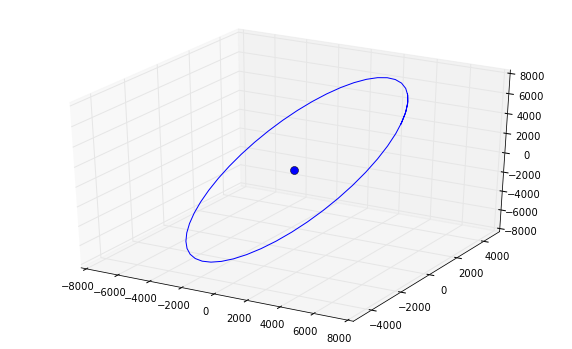

In [29]:
import itertools
i = 0
fig = plt.figure(figsize=[10,6])
ax = fig.gca(projection='3d')

for i in range(len(coe[0])):   
    
    y00  = [rx[i], ry[i], rx[i], vx[i], vy[i], vz[i]] 
    y0  = list(itertools.chain(*y00))  # flatten the list
    
    Tf = T[i] # period in [sec]
    time = np.linspace(0,Tf)
    
    y = odeint(orbit, y0, time)
    X = y[:,0]
    Y = y[:,1]
    Z = y[:,2]
    VX = y[:,3]
    Vy = y[:,4]
    Vz = y[:,5]
    ax.plot(X,Y,Z,'-')
    ax.plot([0], [0], [0], marker='o', markersize=8.0, color='blue')
    

In [30]:
import ephem
import datetime
from datetime import datetime

# Using PyPhem library

In [31]:
name = "ISS (ZARYA)"
line1 = "1 25544U 98067A   16183.98843048  .00016717  00000-0  10270-3 0  9156"
line2 = "2 25544  51.6411 344.1936 0001100  11.0349 349.0828 15.54802532  7286"   

In [32]:
tle_rec = ephem.readtle(name,line1, line2)
tle_rec.compute()

In [33]:
#print (tle_rec.sublong, tle_rec.sublat)
lat = tle_rec.sublat*180/np.pi
lon = tle_rec.sublong*180/np.pi

In [34]:
Madrid = ephem.city('Madrid')
mad_lat = Madrid.lat*180/np.pi
mad_lon = Madrid.lon*180/np.pi

//anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


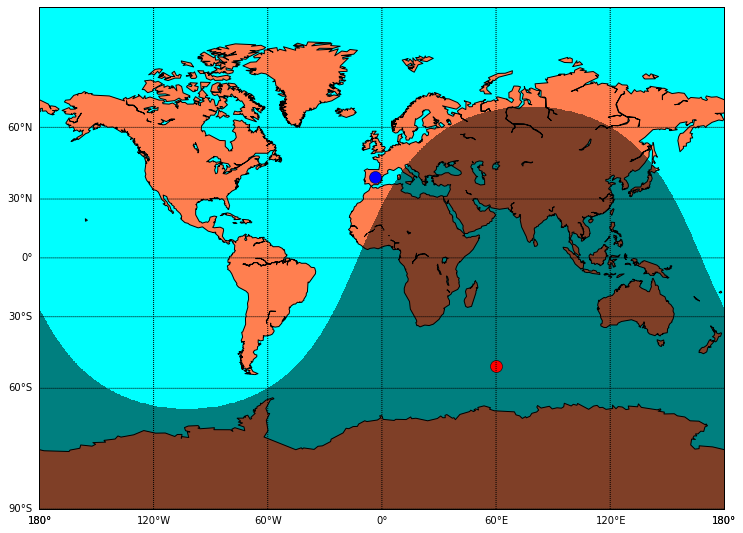

In [35]:
plt.figure(figsize=(18,9))
map = Basemap(projection='mill',lon_0=0)
# plot coastlines, draw label meridians and parallels.
lats = [tle_rec.sublat*180/np.pi, Madrid.lat*180/np.pi]
lons = [tle_rec.sublong*180/np.pi, Madrid.lon*180/np.pi]
x2,y2 = map(mad_lon, mad_lat)
map.plot(x2,y2, 'bo', markersize=12)
x, y = map(lon,lat)
map.plot(x,y, 'ro', markersize=12)
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
# shade the night areas, with alpha transparency so the
# map shows through. Use current time in UTC.
date = datetime.utcnow()
#map.drawmeridians(tle_rec.sublong,tle_rec.sublat)
#lon, lat = -1:34:28.8, 37:43:59.2
CS = map.nightshade(date)

#x1, y1 = map(mad_lon, mad_lat)
#map.scatter(x1,y1, marker='D',color='m')



In [37]:
Madrid = ephem.city('Madrid')
print('%s %s' % (Madrid.lat, Madrid.lon))

40:25:00.1 -3:42:01.2
